In [1]:
%matplotlib inline
import math
from scipy import integrate
import pandas as pd
import functools
import warnings
import LEDs
warnings.filterwarnings('ignore', category=sp.integrate.IntegrationWarning)

#
# Constants
#
sun_ppfd = 2200  # PPFD of the Sun, the one we want to mimick
shelf_surface = 0.51 * 0.72  # The surface to cover at sun PPFD
cost_kwh = 0.26  # Cost of electricity per kWh, considering both supply and delivery charges...
h_light_per_day = 10  # Number of hours per day the LEDs will be turned on
shelf_heights = [0.90, 0.60] # The distance between the bottom and top of the shelves (ignoring pots)


NameError: name 'sp' is not defined

# Comparison of LEDs

In [ ]:
#
# Calculation of costs and quantities
#
def surface_per_led(led_ppf):
    """Calculate the surface (cm2) a single LED covers to produce a PPFD similar to sunlight."""
    return led_ppf / sun_ppfd * 100**2

def leds_per_shelf(led_ppf):
    """Calculate the number of LEDs required to produce sun-like light on one shelf."""
    led_surface = led_ppf / sun_ppfd
    return np.ceil(shelf_surface / led_surface)

def monthly_cost_per_shelf(led_ppf, led_w):
    """Calculate the monthly cost of operating one shelf with sun-like light."""
    shelf_kwh = leds_per_shelf(led_ppf) * led_w / 1000
    return shelf_kwh * h_light_per_day * 365 * cost_kwh / 12

#
# Tools for approximating the ppf of a light source given in lumens
#
h = 6.626e-34
c = 3.0e+8
k = 1.38e-23
nA = 6.022140857e23

def gauss(x, A, mu, sigma):
    """Calculate a gaussian"""
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

def luminosity_function(l):
    """Return the lm/W for the given wavelength"""
    return gauss(l, 683, 559, 42)

#
# Black body light sources
#
def planck(wav, T):
    """
    Calculate the Planck Law for the given temperature.
    
    Stolen from https://stackoverflow.com/questions/22417484/plancks-formula-for-blackbody-spectrum
    """
    a = 2.0*h*c**2
    b = h*c/(wav*k*T)
    intensity = a/ ( (wav**5) * (np.exp(b) - 1.0) )
    return intensity

def eta_mu(T):
    """Calculate the lumens per PAR watts of a black body source of temperature T."""
    def a(l):
        return planck(l, T) * luminosity_function(l*10**9)
    b = sp.integrate.quad(planck, 400e-9, 700e-9, args=T)[0]
    return sp.integrate.quad(a, 400e-9, 700e-9)[0] / b

def eta_photon(T):
    """Calculate the mols of photon per second per PAR watts of a black body source of temperature T."""
    def a(l):
        return planck(l, T) * l / (h * c * nA)
    b = sp.integrate.quad(planck, 400e-9, 700e-9, args=T)[0]
    return sp.integrate.quad(a, 400e-9, 700e-9)[0] / b

def lumen_to_ppf(l, T):
    """Calculate the approximate ppf (in umol/s) of a light source of color temperature T emiting l lumen."""
    return l / eta_mu(T) * eta_photon(T) * 1e6

#
# Any light sources
#
def eta_mu_led(T, f):
    """Calculate the lumens per PAR watts of a LED with spectral distribution f at T °K of temperature T."""
    def a(l):
        return f(l) * luminosity_function(l)
    b = sp.integrate.quad(f, 400, 700, limit=500)[0]
    return sp.integrate.quad(a, 400, 700, limit=500)[0] / b

def eta_photon_led(T, f):
    """Calculate the mols of photon per second per PAR watts of a black body source of temperature T."""
    def a(l):
        return f(l) * l*1e-9 / (h * c * nA)
    b = sp.integrate.quad(f, 400, 700, limit=500)[0]
    return sp.integrate.quad(a, 400, 700, limit=500)[0] / b

def lumen_to_ppf_led(l, T, f):
    """Calculate the approximate ppf (in umol/s) of a light source of color temperature T emiting l lumen."""
    return l / eta_mu_led(T, f) * eta_photon_led(T, f) * 1e6

#
# Better functions for any light source
#
def read_spectrum(f):
    spectrum = pd.read_csv('/home/corentin/Projets/Vertical Garden/Light/Wavelength spectrums/' + f)
    return LEDs.estimate_spectrum(spectrum.iloc[:, 0], spectrum.iloc[:, 1])
# def read_spectrum(f):
#     """
#     Return a list of interpolated graph from a spectral distribution file.
#     It assumes the graph has been exported from WebPlotDigitizer and named as "CCT" or "CCT CRI", such as "3000K" or "3000K 70CRI".
#     """
#     df = pd.read_csv(f, header=[0, 1])
    
#     # Clean up
#     prev, remove, ccts = None, list(), list()
#     for column in df:
#         if 'Unnamed' in column[0]:
#             remove.append(column)
#             df.loc[:, (prev, column[1])] = df[column[0]][column[1]]
#         else:
#             prev = column[0]
#             ccts.append(column[0])
#     df.drop(remove, axis=1, inplace=True)
    
#     # Make a distribution for each CCT
#     dists = dict()
#     for cct in ccts:
#         data = df.loc[:, cct]
#         func = sp.interpolate.interp1d(data['X'], data['Y'], assume_sorted=True)
#         if 'CRI' in cct:
#             cct, cri = cct.split(' ')
#             cct = int(cct[:-1])
#             cri = int(cri[:-3])
#             if cct not in dists:
#                 dists[cct] = dict()
#             dists[cct][cri] = func
#         else:
#             cct = int(cct[:-1]) if cct[:-1].isdigit() else cct
#             dists[cct] = func
#     return dists

def lumen_to_ppf_from_dist(dist_f, l, cct, cri=None, loose=True):
    """
    Estimate PPF (um/s) from the given spectral distribution, lumens, CCT and CRI.
    
    The loose option tolerates imprecisions in CRI and CCT.
    """
    # Get the spectral distribution
    spectrum = read_spectrum(dist_f)
    if cct in spectrum:
        dists = spectrum[cct]
    elif loose == True:
        dists = spectrum[list(spectrum.keys())[np.argmin(np.abs([i - cct for i in spectrum.keys()]))]]
    else:
        raise ValueError('Unknown spectrum for this color temperature')
    if type(dists) != dict:
        dist = dists
    elif (len(dists) == 1 and cri == None and loose == False) or (len(dists) == 1 and loose == True):
        dist = dists[list(dists.keys())[0]]
    elif cri in dists.keys():
        dist = dists[cri]
    else:
        raise ValueError('CRI needs to be defined.')

    # Calculate the value
    eta_mu = sp.integrate.quad(lambda l: dist(l) * luminosity_function(l), 400, 700, limit=500)[0] / sp.integrate.quad(dist, 400, 700, limit=500)[0]
    eta_photon = sp.integrate.quad(lambda l: dist(l) * l*1e-9 / (h * c * nA), 400, 700, limit=500)[0] / sp.integrate.quad(dist, 400, 700, limit=500)[0]
    return l / eta_mu * eta_photon * 1e6


## Samsung

- https://www.digikey.com/products/en?mpart=SI-B8V05128HUS&v=1510
- https://www.digikey.com/product-detail/en/samsung-semiconductor-inc/SPHWHAHDNG27YZV2D2/SPHWHAHDNG27YZV2D2-ND/7069791

In [4]:
leds = pd.read_csv('Light/LEDs.csv', comment='#')
# leds.to_csv('Light/LED wavelength spectrums.csv', index=False)
leds

,$,A,CRI,K,V,brand,lm,sn,note,ppf,series,spectrum
0,13.3000,0.50,80.0,3000.0,48.8,Bridgelux,4336.0,BXRE-30e6500-C-73,NaN,NaN,V22,Bridgelux V22 3000K 80CRI.csv
1,14.5100,0.54,70.0,3000.0,34.6,Citizen,2897.0,CLU038-1206C4-30AL7K3,NaN,NaN,CLU0,Citizen CLU0X8 3000K 70CRI.csv
2,6.0800,0.27,70.0,3000.0,34.6,Citizen,1428.0,CLU028-1203C4-30AL7K3,Minimum order of 54,NaN,CLU0,Citizen CLU0X8 3000K 70CRI.csv
3,28.4900,1.08,70.0,3000.0,34.6,Citizen,5877.0,CLU048-1212C4-30AL7K3,NaN,NaN,CLU0,Citizen CLU0X8 3000K 70CRI.csv
4,9.4325,0.45,70.0,3000.0,34.6,Citizen,2357.0,CLU036-1205C1-30AL7G4,Minimum order of 48,NaN,CLU0,Citizen CLU0X8 3000K 70CRI.csv
5,3.5700,0.09,70.0,3000.0,34.6,Citizen,491.0,CLU028-1201C4-30AL7K3,Minimum order of 54,NaN,CLU0,Citizen CLU0X8 3000K 70CRI.csv
6,12.1200,0.45,70.0,3000.0,34.6,Citizen,2439.0,CLU038-1205C4-30AL7K3,NaN,NaN,CLU0,Citizen CLU0X8 3000K 70CRI.csv
7,4.8300,0.72,80.0,3000.0,37.2,Luminus,4940.0,CHM-11-30-80-36-XH20-F3-3,"Minimum of 1,125 LED/order",NaN,XNova,Luminus XNova CHM11 3000K 80CRI.csv
8,6.7300,0.96,90.0,3000.0,36.0,Luminus,2815.0,CHM-11-30-90-36-XH00-F2-3,NaN,NaN,XNova,Luminus XNova CHM11 3000K 90CRI.csv
9,3.6500,0.48,80.0,3000.0,27.4,Luminus,1590.0,CHM-6-30-80-27-XH20-F3-3,NaN,NaN,XNova,Luminus XNova CHM11 3000K 80CRI.csv


In [5]:
for i, p in enumerate(leds['ppf'].isnull()):
    if p == True:
        leds.set_value(i, 'ppf', lumen_to_ppf_from_dist(leds.iloc[i]['spectrum'], leds.iloc[i]['lm'], leds.iloc[i]['K'], leds.iloc[i]['CRI']))
leds.set_index(['brand', 'series','model'], inplace=True)
leds.sort_index(inplace=True)
leds

AttributeError: module 'LEDs' has no attribute 'estimate_spectrum'

In [ ]:
leds['W'] = leds['A'] * leds['V']
leds['lm/W'] = leds['lm']/leds['W']
leds['ppf/$'] = leds['ppf'] / leds['$']
leds['ppf/W'] = leds['ppf'] / leds['W']
leds['leds/shelf'] = leds_per_shelf(leds['ppf'])
leds['cm2/led'] = surface_per_led(leds['ppf'])
leds['sqrt(cm2/led)'] = np.sqrt(surface_per_led(leds['ppf']))
leds['$/shelf'] = leds['$'] * leds['leds/shelf']
leds['$/month'] = monthly_cost_per_shelf(leds['ppf'], leds['W'])
leds['$/shelf/3y'] = leds['$/shelf'] + 36 * leds['$/month']
leds.sort_values('$/shelf/3y', inplace=True)
leds = leds.reindex_axis(['K', 'CRI', '$', '$/shelf', '$/month', '$/shelf/3y', 'A', 'V', 'W', 'lm', 'ppf', 'lm/W', 'ppf/W', 'ppf/$', 'leds/shelf', 'cm2/led', 'sqrt(cm2/led)', 'spectrum', 'www', 'note'], axis=1)

In [10]:
leds

K   CRI        $  $/shelf  \
brand     series  model                                                       
Luminus   XNova   CHM-11-30-80-36-XH20-F3-3  3000.0  80.0   4.8300   53.130   
Bridgelux V22     BXRE-30e6500-C-73          3000.0  80.0  13.3000  172.900   
          Vero 10 BXRC-50C1001-D-74          5000.0  70.0   3.5800  139.620   
                   BXRC-40E1000-D-73         4000.0  80.0   3.5800  146.780   
          Vero 13 BXRC-30E2000-D-73          3000.0  80.0   5.8200  151.320   
          Vero 18 BXRC-30E4000-D-73          3000.0  80.0   9.7900  137.060   
          Vero 10 BXRC-30E1000-D-73          3000.0  80.0   3.5800  164.680   
          Vero 13 BXRC-27E2000-D-73          2700.0  80.0   5.8200  157.140   
Luminus   XNova   CHM-6-30-80-27-XH20-F3-3   3000.0  80.0   3.6500  124.100   
Cree      CXA2    CXB2530                    4000.0  70.0  12.8340  179.676   
          MH      MHBB                          NaN   NaN   1.7200  173.720   
                  MHDG                       5000.0   NaN   4.9500  173.250   
          CXA2    CXB3590-0000-000R0BCD50e   5000.0  70.0  41.1900  205.950   
Citizen   CLU0    CLU028-1203C4-30AL7K3      3000.0  70.0   6.0800  255.360   
                  CLU036-1205C1-30AL7G4      3000.0  70.0   9.4325  245.245   
Cree      MH      MHDEWT-0000-000N0HG430G    3000.0  80.0   2.5650  171.855   
Citizen   CLU0    CLU038-1205C4-30AL7K3      3000.0  70.0  12.1200  303.000   
                  CLU038-1206C4-30AL7K3      3000.0  70.0  14.5100  304.710   
Bridgelux Vero 10 BXRC-30G1000-C-73          3000.0  90.0   4.5030  198.132   
                   BXRC-30G1000-D-73         3000.0  90.0   3.5800  200.480   
Citizen   CLU731  CLU731-1210C4-403M2K1      4000.0   NaN  21.5000  172.000   
Cree      CXA2    CXB3070-0000-000N0UZ230G   3000.0  90.0  32.9500  230.650   
Citizen   CLU0    CLU048-1212C4-30AL7K3      3000.0  70.0  28.4900  313.390   
Cree      CXA2    CXB3070-0000-000N0HAD30G   3000.0  80.0  36.0600  252.420   
Luminus   XNova   CHM-11-30-90-36-XH00-F2-3  3000.0  90.0   6.7300  121.140   
Citizen   CLU0    CLU028-1201C4-30AL7K3      3000.0  70.0   3.5700  439.110   
Cree      XP      XHP702                     5000.0   NaN  13.1100  432.630   
Bridgelux Vero 10 BXRC-30G1000-B-23          3000.0  90.0   3.6850  232.155   
          H       BXRC-40E1000-D-73          4000.0   NaN  15.1100  120.880   
Cree      XP      XPG3                          NaN   NaN   1.6100  592.480   

                                               $/month   $/shelf/3y     A  \
brand     series  model                                                     
Luminus   XNova   CHM-11-30-80-36-XH20-F3-3   9.857628   408.004608  0.72   
Bridgelux V22     BXRE-30e6500-C-73          10.612983   554.967400  0.50   
          Vero 10 BXRC-50C1001-D-74          11.874362   567.097050  0.35   
                   BXRC-40E1000-D-73         12.483304   596.178950  0.35   
          Vero 13 BXRC-30E2000-D-73          13.440213   635.167650  0.50   
          Vero 18 BXRC-30E4000-D-73          13.919001   638.144045  1.05   
          Vero 10 BXRC-30E1000-D-73          13.628583   655.308985  0.35   
          Vero 13 BXRC-27E2000-D-73          13.957144   659.597175  0.50   
Luminus   XNova   CHM-6-30-80-27-XH20-F3-3   14.961496   662.713856  0.48   
Cree      CXA2    CXB2530                    13.490400   665.330400  0.80   
          MH      MHBB                       14.598540   699.267440  0.48   
                  MHDG                       14.837098   707.385525  0.35   
          CXA2    CXB3590-0000-000R0BCD50e   14.454000   726.294000  2.40   
Citizen   CLU0    CLU028-1203C4-30AL7K3      13.127846   727.962438  0.27   
                  CLU036-1205C1-30AL7G4      13.544603   732.850690  0.45   
Cree      MH      MHDEWT-0000-000N0HG430G    16.140300   752.905800  0.80   
Citizen   CLU0    CLU038-1205C4-30AL7K3      13.023656   771.851625  0.45   
                  CLU038-1206C4-30AL7K3      13.127846   7

In [11]:
leds[leds['K'] <= 3000]

K   CRI        $  $/shelf  \
brand     series  model                                                       
Luminus   XNova   CHM-11-30-80-36-XH20-F3-3  3000.0  80.0   4.8300   53.130   
Bridgelux V22     BXRE-30e6500-C-73          3000.0  80.0  13.3000  172.900   
          Vero 13 BXRC-30E2000-D-73          3000.0  80.0   5.8200  151.320   
          Vero 18 BXRC-30E4000-D-73          3000.0  80.0   9.7900  137.060   
          Vero 10 BXRC-30E1000-D-73          3000.0  80.0   3.5800  164.680   
          Vero 13 BXRC-27E2000-D-73          2700.0  80.0   5.8200  157.140   
Luminus   XNova   CHM-6-30-80-27-XH20-F3-3   3000.0  80.0   3.6500  124.100   
Citizen   CLU0    CLU028-1203C4-30AL7K3      3000.0  70.0   6.0800  255.360   
                  CLU036-1205C1-30AL7G4      3000.0  70.0   9.4325  245.245   
Cree      MH      MHDEWT-0000-000N0HG430G    3000.0  80.0   2.5650  171.855   
Citizen   CLU0    CLU038-1205C4-30AL7K3      3000.0  70.0  12.1200  303.000   
                  CLU038-1206C4-30AL7K3      3000.0  70.0  14.5100  304.710   
Bridgelux Vero 10 BXRC-30G1000-C-73          3000.0  90.0   4.5030  198.132   
                   BXRC-30G1000-D-73         3000.0  90.0   3.5800  200.480   
Cree      CXA2    CXB3070-0000-000N0UZ230G   3000.0  90.0  32.9500  230.650   
Citizen   CLU0    CLU048-1212C4-30AL7K3      3000.0  70.0  28.4900  313.390   
Cree      CXA2    CXB3070-0000-000N0HAD30G   3000.0  80.0  36.0600  252.420   
Luminus   XNova   CHM-11-30-90-36-XH00-F2-3  3000.0  90.0   6.7300  121.140   
Citizen   CLU0    CLU028-1201C4-30AL7K3      3000.0  70.0   3.5700  439.110   
Bridgelux Vero 10 BXRC-30G1000-B-23          3000.0  90.0   3.6850  232.155   

                                               $/month  $/shelf/3y     A  \
brand     series  model                                                    
Luminus   XNova   CHM-11-30-80-36-XH20-F3-3   9.857628  408.004608  0.72   
Bridgelux V22     BXRE-30e6500-C-73          10.612983  554.967400  0.50   
          Vero 13 BXRC-30E2000-D-73          13.440213  635.167650  0.50   
          Vero 18 BXRC-30E4000-D-73          13.919001  638.144045  1.05   
          Vero 10 BXRC-30E1000-D-73          13.628583  655.308985  0.35   
          Vero 13 BXRC-27E2000-D-73          13.957144  659.597175  0.50   
Luminus   XNova   CHM-6-30-80-27-XH20-F3-3   14.961496  662.713856  0.48   
Citizen   CLU0    CLU028-1203C4-30AL7K3      13.127846  727.962438  0.27   
                  CLU036-1205C1-30AL7G4      13.544603  732.850690  0.45   
Cree      MH      MHDEWT-0000-000N0HG430G    16.140300  752.905800  0.80   
Citizen   CLU0    CLU038-1205C4-30AL7K3      13.023656  771.851625  0.45   
                  CLU038-1206C4-30AL7K3      13.127846  777.312438  0.54   
Bridgelux Vero 10 BXRC-30G1000-C-73          16.371966  787.522758  0.33   
                   BXRC-30G1000-D-73         16.591318  797.767460  0.35   
Cree      CXA2    CXB3070-0000-000N0UZ230G   16.019850  807.364600  1.90   
Citizen   CLU0    CLU048-1212C4-30AL7K3      13.752981  808.497316  1.08   
Cree      CXA2    CXB3070-0000-000N0HAD30G   16.019850  829.134600  1.90   
Luminus   XNova   CHM-11-30-90-36-XH00-F2-3  20.813760  870.435360  0.96   
Citizen   CLU0    CLU028-1201C4-30AL7K3      12.815278  900.459999  0.09   
Bridgelux Vero 10 BXRC-30G1000-B-23          19.550541  935.974462  0.35   

                                                V       W      lm         ppf  \
brand     series  model                                                         
Luminus   XNova   CHM-11-30-80-36-XH20-F3-3  37.2  26.784  4940.0   74.894578   
Bridgelux V22     BXRE-30e6500-C-73          48.8  24.400  4336.0   62.249355   
          Vero 13 BXRC-30E2000-D-73          30.9  15.450  2232.0   31.998674   
          Vero 18 BXRC-30E4000-D-73          28.3  29.715  4248.0   60.900703   
          Vero 10 BXRC-30E1000-D-73          25.3   8.855  1229.0   17.619342   
          Vero 13 BXRC-27E2000-D-73          30.9  15.450  2129.0   30.

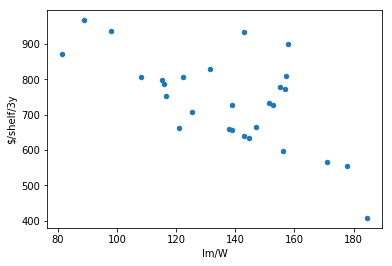

In [12]:
leds[['lm/W', '$/shelf/3y']].dropna().plot('lm/W', '$/shelf/3y', 'scatter')
# leds[['lm/W', 'K']].dropna().plot('K', 'lm/W', 'scatter')

It looks like the least costly option will correlate with the lm/W of the LED. Hence, search by lm/W may be a good idea, although I may miss some great solution.
https://www.digikey.com/products/en/optoelectronics/led-lighting-cobs-engines-modules/111?k=&pkeyword=&pv1614=74&pv1614=304&pv1614=343&pv1614=303&pv1614=363&FV=150000df%2C15000106%2C15000118%2C1500011a%2C15000123%2C15000125%2C15000137%2C15000145%2C1500014c%2C1500014e%2C1500015f%2C1500019b%2C1500019d%2C150001c1%2C150001c4%2C150001c7%2C150001d5%2C150001db%2C150001f5%2C150001f6%2C150001fa%2C1938000a%2C1938000d%2C1938001c%2C19380122%2C19380123%2C1938012f%2C19380130%2C19380131%2C19380132%2C1938014e%2C19380157%2C19380159%2C1938015a%2C19380160%2C19380167%2C19380168%2C1938016b%2C1938018a%2C19380190%2C193801d0%2C193801da%2C193801eb%2C193801ed%2C193801f7%2C193801f9%2C193801fb%2C1938004a%2Cffe0006f&mnonly=0&ColumnSort=-1344&page=1&quantity=0&ptm=0&fid=0&pageSize=25


0.00328649600294 0.187397525714


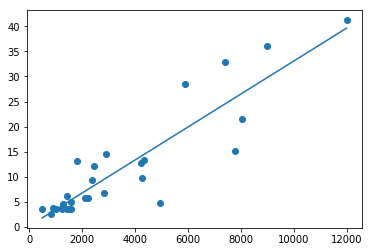

In [60]:
source = leds[['$', 'lm']].dropna()
m, b = np.polyfit(source['lm'], source['$'], 1)
plt.scatter(leds['lm'], leds['$'])
x = np.linspace(np.min(leds['lm']), np.max(leds['lm']), 1000)
plt.plot(x, m * x + b)
print(m, b)
plt.show()

Also, it looks like the cost of LEDs grow linearly with their lumens.

The spectrum at 3000K, 90CRI has peaks closer to the chlorophyll absportion peaks than at 70CRI. https://www.digikey.com/products/en/optoelectronics/led-lighting-cobs-engines-modules/111?k=&pkeyword=&pv1615=3&pv1615=17&pv1615=36&pv1615=6&pv1615=28&pv1615=48&pv1615=47&FV=1938012f%2C19380130%2C19380157%2C1938016b%2C1938004a%2Cffe0006f&mnonly=0&ColumnSort=-1344&page=1&quantity=0&ptm=0&fid=0&pageSize=25

I should also look into 2700K lights.

# Distribution of light

LEDs do not distribute light uniformely across, and do not have the ideal angle to provide the PPFD at a given height. Hence, lenses and reflectors must be used, and compromises must be made.

In [6]:
precision = 0.005
w, d, h  = 0.72, 0.51, 0.7

In [7]:
def lambertian(x, I0, m):
    return I0 * np.cos(np.radians(x))**m

def lens_crafter(f):
    lens = pd.read_csv(f, header=1)
    boundary = abs(lens['X'].iloc[lens['Y'].argmin()])
    lens = lens.append({'X': -90, 'Y': 0}, ignore_index=True)
    lens = lens.append({'X': 90, 'Y': 0}, ignore_index=True)
    lens.sort_values('X', inplace=True) 
    lens_interp = sp.interpolate.interp1d(lens['X'], lens['Y'], assume_sorted=True)
    def dist(x):
        mask = np.logical_and(np.greater(x, -boundary), np.less(x, boundary))
        return lens_interp(x) * mask
    return dist

def drd(x, y, h, ard):
    """
    Distal Radiation Distribution.
    
    Given:
     - the height h of the LED from the illuminated ground
     - the angular radiation distribution ard, taking deg
    the relative intensity at position (x, y), in meters, is returned.
    """
    b = np.sqrt(x**2 + y**2)
    theta = np.degrees(np.arctan(b/h))
    return ard(theta)

def dfdd(x, y, h, ard, auc, ppf):
    """Distal flux density distribution, as umol/(s*m**2) against m**2"""
    return drd(x, y, h, ard) * ppf / auc

def fdd(w, d, positions, h, ard, auc, ppf, precision=0.005):
    """
    Flux density distribution on a given surface.
    
    Arguments:
    - w: the width of the surface (m)
    - d: the depth of the surface (m)
    - positions: the positions of the LEDs on the surface, as a list of (x, y), with x E (0, w) and y E (0, d)
    - h: the vertical distance between the LEDs and the surface (m)
    - ard: the angular radiation distribution of the LED (function)
    - auc: the area under the curve of the LED's distal radiation distribution
    - ppf: the photosynthetic photon flux of the LED
    - precision: the distance between two points for the simulation (m). Smaller numbers make finer drawings.
    """
    xs, ys = np.arange(0, w, precision), np.arange(0, d, precision)
    plot = np.zeros((len(ys), len(xs)))
    for c_x, c_y in positions:
        x, y = np.meshgrid(xs - c_x, ys - c_y)
        plot += dfdd(x, y, h, ard, auc, ppf)
    return plot    

def show_lens(lens):
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    x = np.linspace(-90, 90, 1000)
    plt.plot(x, lens(x))
    fit = sp.optimize.curve_fit(lambertian, x, lens(x), p0=(lens(0), 10))
    plt.plot(x, lambertian(x, *fit[0]))

    plt.subplot(122)
    x = np.linspace(-0.35, 0.35, 100)
    y = np.linspace(-0.25, 0.25, 100)
    x, y = np.meshgrid(x, y)
    z = drd(x, y, h, lens)
    # plt.axes().set_aspect('equal')
    plt.pcolor(x, y, z)
    plt.colorbar()
    plt.show()

def view_field(w, d, pos, h, lens, auc, PPF):
    """Show the simulated field of light and its PPF exceedance curve"""
    field = fdd(w, d, pos, h, lens, auc, PPF)
    plt.figure(figsize=(18,6))
    plt.subplot(121, aspect='equal')
    plt.contourf(field)
    plt.colorbar()
    plt.subplot(122)
    plt.hist(field.flatten(), cumulative=-1, normed=True)
    plt.show()
    
def eval_uniformity(x):
    """Evaluate the uniformity of a given plane"""
    return np.stdev(x) / np.mean(x)

def eval_uniformity2(x):
    """Evaluate the uniformity of a given plane"""
    return np.max(x) - np.min(x) / np.max(x)
    
def eval_sunniness(x):
    """Evalutate the fraction of cells around sunlight, but not above."""
#     tot = np.product(x.shape)
#     return 1 - np.sum(np.logical_and(x <= sun_ppfd, x >= sun_ppfd * 0.8)) / tot
    return np.sqrt(np.mean((x - sun_ppfd)**2))/sun_ppfd

def eval_burning(x):
    """Evaluate the percentage of cells above sun light."""
    return np.sum(x > sun_ppfd) / np.product(x.shape)

def eval_light_loss(x):
    """Evaluate the fraction of light lost off the shelf."""
    return 1 - np.sum(x) / (sun_ppfd * np.product(x.shape))
    
def eval_positions(p, w, d, h, ard, auc, ppf, precision):
    """Evaluate the given LED positions for uniformity using eval_uniformity"""
    dist = fdd(w, d, p, h, ard, auc, ppf, precision)
    return np.mean(eval_uniformity2(dist) + eval_light_loss(dist) + eval_burning(dist))
    
    
def random_positions(w, d, n):
    """Output a random list of n positions between (0, w) in x and (0, d) in y."""
    positions = np.zeros((n, 2))
    positions[:, 0] = np.random.randint(0, w * 100, n) / 100
    positions[:, 1] = np.random.randint(0, d * 100, n) / 100
    return positions


def morano(lens, auc, efficiency):
    """ Using results from "Designing light-emitting diode arrays for uniform near-field irradiance", Morano 2006, OSA"""
#     m = - np.log(2)/np.log(np.cos(np.radians(fwhm)))  # Too imprecise
    x = np.linspace(-90, 90, 1000)
    fit = sp.optimize.curve_fit(lambertian, x, lens(x), p0=(lens(0), 10))  # Approximate a lambertian emitter to get m
    space = np.sqrt(1.2125/(fit[0][1]-3.349)) * h  # Aligned array from Moreno et al 2005
    x, y = np.arange(0, w + space, space), np.arange(0, d + space, space)
    positions = np.array(np.meshgrid(x,y)).T.reshape(len(x)*len(y),2)
    print("{0} LEDs with an estimated m of {1:.2f} spaced {2:.3f}m away from each other".format(len(positions), fit[0][1], space))
    
    return positions


def uniform_spacing_rectangle(w, d, n):
    """
    Generate a light field by positioning LEDS equidistantly in a rectangular fashion
    
    Should look into this to be able to use the exact number of LEDs: https://www.google.com/search?q=packing+circles+in+a+square&oq=packing+circles+in+a+square&gs_l=psy-ab.3..0j0i22i30k1l3.260412.264878.0.265455.27.24.0.0.0.0.291.3337.0j15j5.20.0....0...1.1.64.psy-ab..7.20.3331...35i39k1j0i67k1j0i20k1.0.EUPmkYp_Qy4
  
    w: width of the illumination area (m)
    d: depth of the illumination area (m)
    h: height of the LEDs from the illumination area (m)
    n: number of LEDs in the system
    """
    n_w = int(round(np.sqrt(w*n/d),0))
    n_d = int(round(n / n_w))
    x, y = np.meshgrid(range(n_w), range(n_d))
    unit_w = w / n_w
    unit_d = d / n_d
    positions = np.stack([(x.ravel() + 0.5) * unit_w, (y.ravel() + 0.5) * unit_d], 1)
    return positions, n_w * n_d


def uniform_spacing_hexagon(w, d, n):
    """
    Generate a light field by positioning LEDS equidistantly in a hexagonal fashion
    
    Should look into this to be able to use the exact number of LEDs: https://www.google.com/search?q=packing+circles+in+a+square&oq=packing+circles+in+a+square&gs_l=psy-ab.3..0j0i22i30k1l3.260412.264878.0.265455.27.24.0.0.0.0.291.3337.0j15j5.20.0....0...1.1.64.psy-ab..7.20.3331...35i39k1j0i67k1j0i20k1.0.EUPmkYp_Qy4
  
    w: width of the illumination area (m)
    d: depth of the illumination area (m)
    h: height of the LEDs from the illumination area (m)
    n: number of LEDs in the system
    """
    n_w = int(round(np.sqrt(w*n/d),0))
    n_d = int(round(n / n_w))
    x, y = np.meshgrid(range(n_w), range(n_d))    
    unit_w = w / n_w
    unit_d = d / n_d
    positions = np.stack([(x.ravel() + 0.25 + y.ravel() % 2 * 0.5) * unit_w, (y.ravel() + 0.5) * unit_d], 1)
    return positions, n_w * n_d


def lsuniformity(w, d, h, n, ard, auc, ppf, precision=0.01, start_organized=False):
    """
    Local search algorithm to design a uniform light field.
    
    LEI, P.; WANG, Q.; ZOU, H.. Designing LED array for uniform illumination based on local search algorithm. 
    Journal of the European Optical Society - Rapid publications, Europe, v. 9, mar. 2014. ISSN 1990-2573. 
    Available at: <https://www.jeos.org/index.php/jeos_rp/article/view/14014>. Date accessed: 26 Jul. 2017. doi:472. 
    
    w: width of the illumination area (m)
    d: depth of the illumination area (m)
    h: height of the LEDs from the illumination area (m)
    n: number of LEDs in the system
    ard: the angular radiation distribution of the LED (function)
    auc: the area under the curve of the LED's distal radiation distribution
    ppf: the photosynthetic photon flux of the LED
    precision: the distance between two points for the simulation (m). Smaller numbers make finer drawings.
    start_organized: if True, will start with a uniformely spaced LEDs. If not, will start with a random distribution
    """
    # Generate random positions
    positions = random_positions(w, d, n) if start_organized == False else uniform_spacing(w, d, n)
 
    # Initiate the variables
    betterd = True
    score = eval_positions(positions, w, d, h, ard, auc, ppf, precision)
    moves = [(precision, 0), (-precision, 0), (0, precision), (0, -precision)]

    # Iterate
    while betterd == True:
        betterd = False  # Reinitiate "counter"
        for k in range(0, n):
            alt_pos = list()
            # Build alternative positions
            for i in moves:
                p = positions.copy()
                p[k] += i
                if (p[k] > 0).all() == True and (p[k] - [w, d] < 0).all() == True and (np.abs(p[np.arange(len(p)) != k] - p[k]) > precision).all() == True :
                    alt_pos.append(p)
            # Rank alternative positions
            if len(alt_pos) > 0:
                alt_scores = [eval_positions(p, w, d, h, ard, auc, ppf, precision) for p in alt_pos]
                best_alt_score = np.min(alt_scores)
                best_alt_pos = alt_pos[alt_scores.index(best_alt_score)]
                # Update position list
                if best_alt_score < score:
                    score = best_alt_score
                    positions = best_alt_pos
                    betterd = True

    return positions, score

def lsuniformity_loop(w, d, h, n, ard, auc, ppf, precision=0.01, T=50):
    results = [lsuniformity(w, d, h, n, ard, auc, ppf, precision) for i in range(T)]
    scores = [results[i][1] for i in range(T)]
    best_score, best_pos = np.min(scores), np.argmin(scores)
    return results[best_pos][0], best_score

def rsuniformity(w, d, h, n, ard, auc, ppf, precision=0.01, T=5000, iterations=10):
    """
    Random search algorithm to design a uniform light field.
    
    Su, Z., Xue, D. & Ji, Z. Designing LED array for uniform illumination distribution by simulated annealing algorithm. Optics express 20, A843–A855 (2012).
    
    See lsuniformity for arguments.
    
    If you ask me, this algorithm is complete garbage. It's randomly searching for an ideal solution, and it does it poorly.

    """
    # Initial values
    k = 1.38064852e-23  # Boltzmann constant
    best_positions = random_positions(w, d, n)
    best_score = eval_positions(best_positions, w, d, h, ard, auc, ppf, precision)
    last_best_score = 1
    
    # Iterate
    H = 0
    while best_score > 0.05 and abs(last_best_score - best_score) / last_best_score > 0.01:
#         print(best_score, abs(last_best_score - best_score) / last_best_score, H)
        last_best_score = best_score
        H += 1
        keep_going = False
        for j in range(iterations):
            positions = random_positions(w, d, n)
            score = eval_positions(positions, w, d, h, ard, auc, ppf, precision)
            W = np.random.random()
            if score < best_score or W < np.exp(-1 * (score - best_score) / (k * T)):
                best_score = score
                best_positions = positions
        T = 0.95**H * T
        
    return best_positions, best_score

In [10]:
uniform_spacing_rectangle(w, d, int(15))


(array([[ 0.072,  0.085],
        [ 0.216,  0.085],
        [ 0.36 ,  0.085],
        [ 0.504,  0.085],
        [ 0.648,  0.085],
        [ 0.072,  0.255],
        [ 0.216,  0.255],
        [ 0.36 ,  0.255],
        [ 0.504,  0.255],
        [ 0.648,  0.255],
        [ 0.072,  0.425],
        [ 0.216,  0.425],
        [ 0.36 ,  0.425],
        [ 0.504,  0.425],
        [ 0.648,  0.425]]), 15)

In [15]:
T = 5000
stepsize = 0.05

In [16]:
LED = leds[leds['K'] == 3000].loc['Bridgelux','V22'].sort_values('$/shelf/3y').iloc[0]
PPF = LED['ppf']
LED

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:1: PerformanceWarning: indexing past lexsort depth may impact performance.
  if __name__ == '__main__':


K                             3000
CRI                             80
$                             13.3
$/shelf                      172.9
$/month                     10.613
$/shelf/3y                 554.967
A                              0.5
V                             48.8
W                             24.4
lm                            4336
ppf                        62.2494
lm/W                       177.705
ppf/W                       2.5512
ppf/$                       4.6804
leds/shelf                      13
cm2/led                    282.952
sqrt(cm2/led)              16.8212
spectrum         Bridgelux V22.csv
www                            NaN
note                           NaN
Name: BXRE-30e6500-C-73, dtype: object

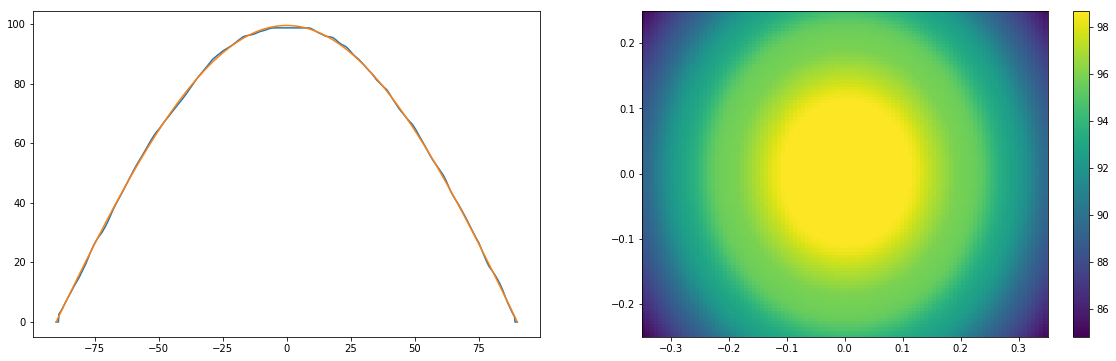

In [17]:
ard = lens_crafter('Light/Angular radiation patterns/Bridgelux V22.csv')
show_lens(ard)

In [18]:
# auc = sp.integrate.nquad(drd, [[-10, 10], [-10, 10]], args=(h, ard))
auc = {0.5: (3392.3268983668577, 0.31720148179194796),
       0.7: (4764.460736525954, 0.36117985500874283)}
auc = auc[h]

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:124: RuntimeWarning: invalid value encountered in sqrt


0 LEDs with an estimated m of 0.99 spaced nanm away from each other


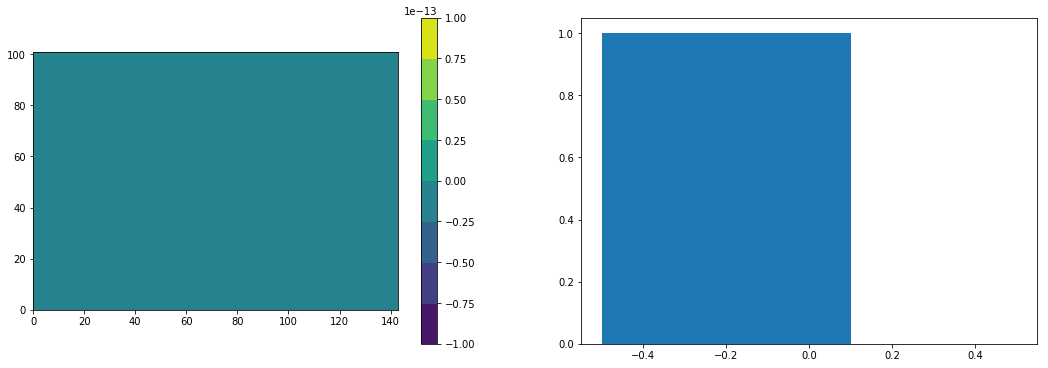

In [19]:
view_field(w, d, morano(ard, auc[0], 1), h, ard, auc[0], PPF)

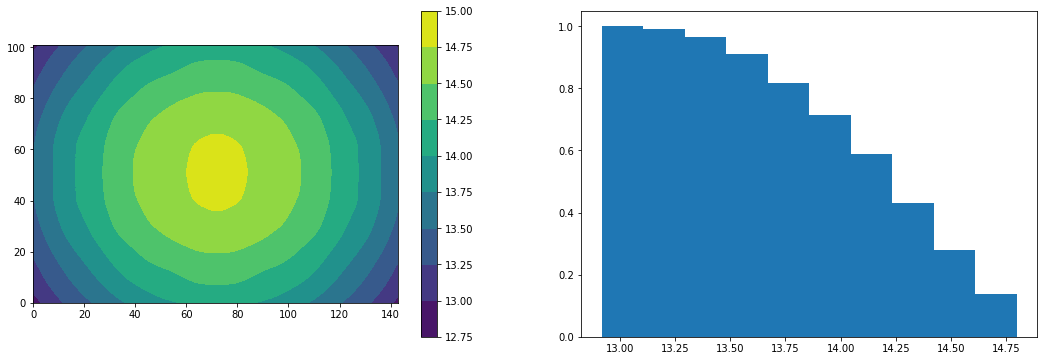

12


In [20]:
pos, n = uniform_spacing_rectangle(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, ard, auc[0], PPF)
print(n)

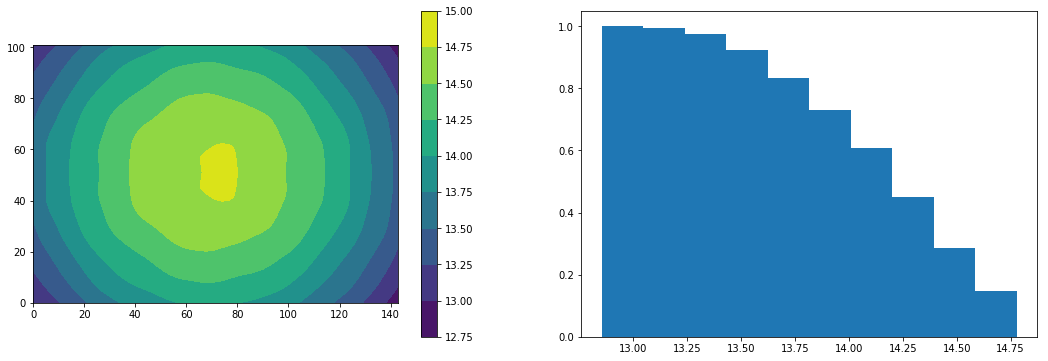

12


In [21]:
pos, n = uniform_spacing_hexagon(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, ard, auc[0], PPF)
print(n)

# Reflectors and lenses

## Kathod Cosmo PLL2008NA

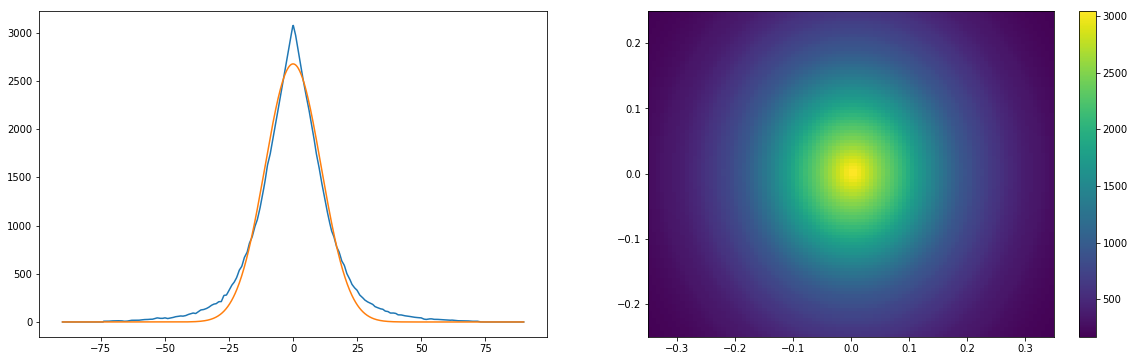

In [22]:
lens = lens_crafter('Light/Lenses/Khatod PLL2008NA V22.csv')
efficiency, fwhm = 1, 20
show_lens(lens)

In [23]:
# auc = sp.integrate.nquad(drd, [[-5, 5], [-5, 5]], args=(h, lens))
auc = {0.5: (340.83517465442014, 4.360595713946395),
       0.7: (667.9288560430372, 10.06627539397357)}
auc = auc[h]

### Morano

30 LEDs with an estimated m of 27.51 spaced 0.157m away from each other


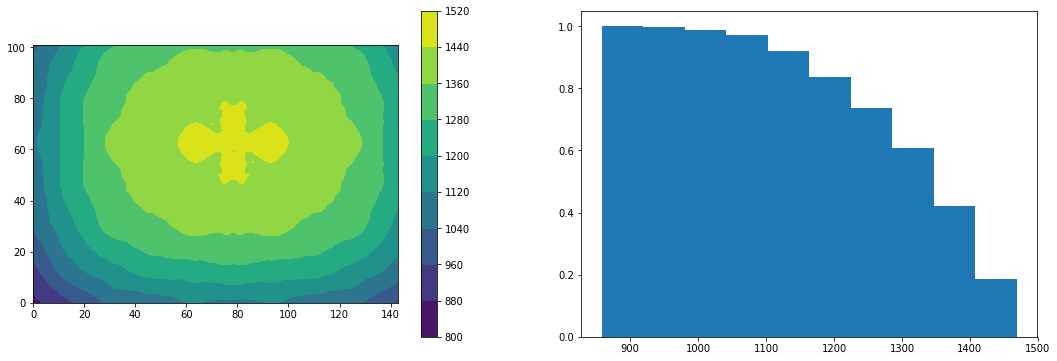

In [24]:
view_field(w, d, morano(lens, auc[0], 1), h, lens, auc[0], PPF)

### Uniform spacing

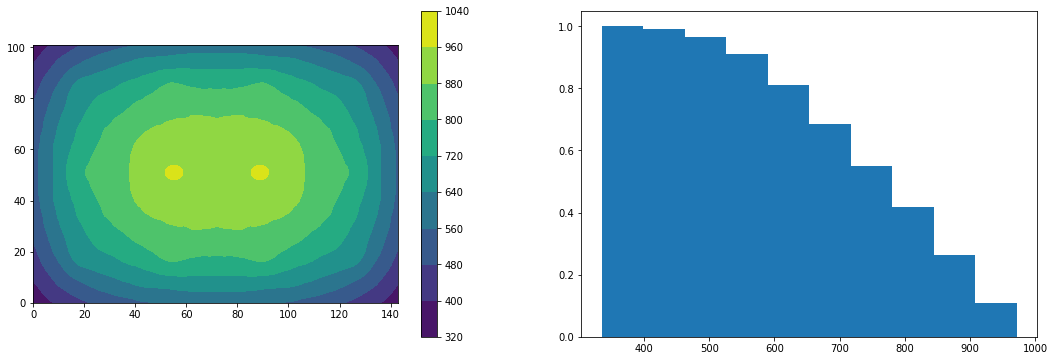

12


In [25]:
pos, n = uniform_spacing_rectangle(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, lens, auc[0], PPF)
print(n)

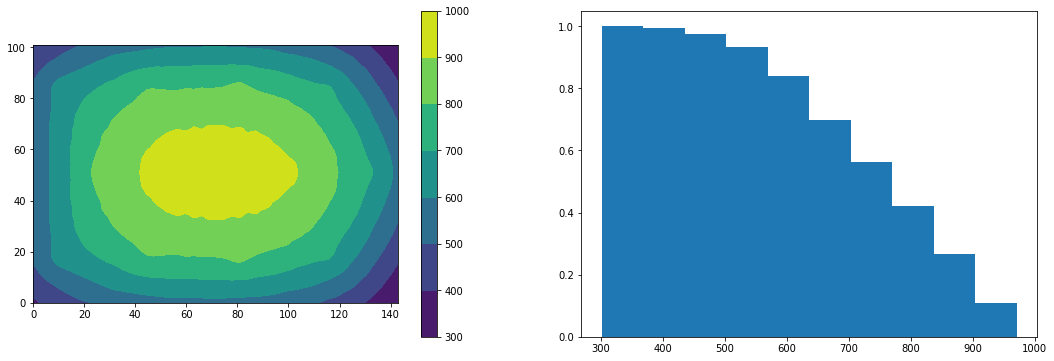

12


In [26]:
pos, n = uniform_spacing_hexagon(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, lens, auc[0], PPF)
print(n)

### Lei

### Su

## LEDil Angela S F13379

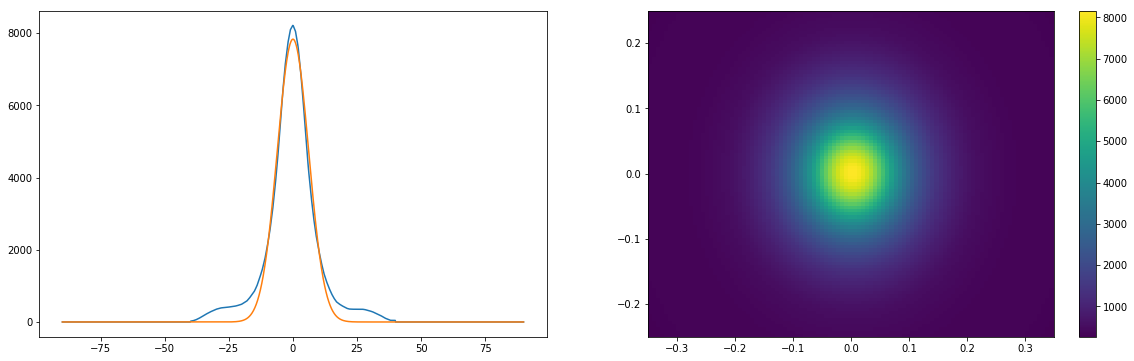

In [27]:
lens = lens_crafter('Light/Lenses/LEDil F13379 V22.csv')
efficiency, fwhm = 0.93, 12
show_lens(lens)

In [28]:

def two_lambertian(x, I1, m1, I2, m2):
    return I1 * np.cos(np.radians(x))**m1 + I2 * np.cos(np.radians(x))**m2

def show_lens2(lens):
    plt.figure(figsize=(20,6))
    plt.subplot(121)
    x = np.linspace(-90, 90, 1000)
    plt.plot(x, lens(x))
    fit = sp.optimize.curve_fit(two_lambertian, x, lens(x), p0=(lens(0), 10, lens(0) / 20, 50))
    plt.plot(x, two_lambertian(x, *fit[0]))

    plt.subplot(122)
    x = np.linspace(-0.35, 0.35, 100)
    y = np.linspace(-0.25, 0.25, 100)
    x, y = np.meshgrid(x, y)
    z = drd(x, y, h, lens)
    # plt.axes().set_aspect('equal')
    plt.pcolor(x, y, z)
    plt.colorbar()
    plt.show()

/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in power
  app.launch_new_instance()
/usr/lib/python3.6/site-packages/ipykernel/__main__.py:3: RuntimeWarning: overflow encountered in multiply
  app.launch_new_instance()


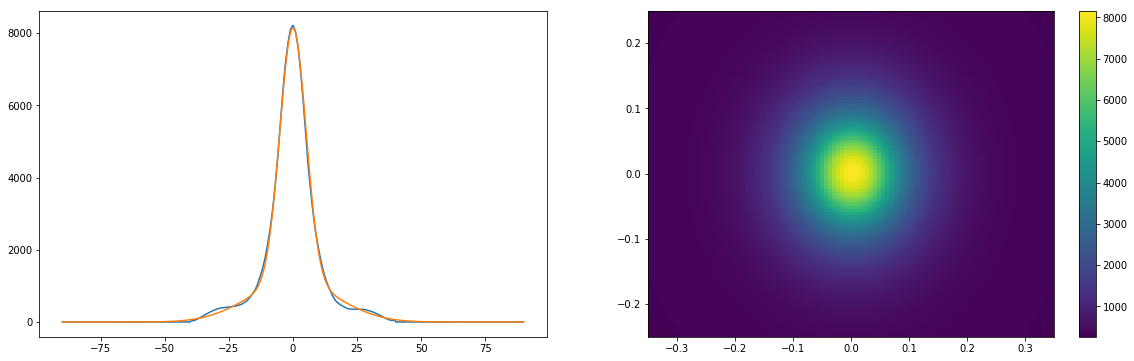

In [29]:
show_lens2(lens)

In [30]:
# auc = sp.integrate.nquad(drd, [[-5, 5], [-5, 5]], args=(h, lens))
auc = {0.5: (259.35356263321256, 1.457204977577021),
       0.7: (508.23105639962614, 2.0801846927280936)}
auc = auc[h]

### Morano

80 LEDs with an estimated m of 87.64 spaced 0.084m away from each other


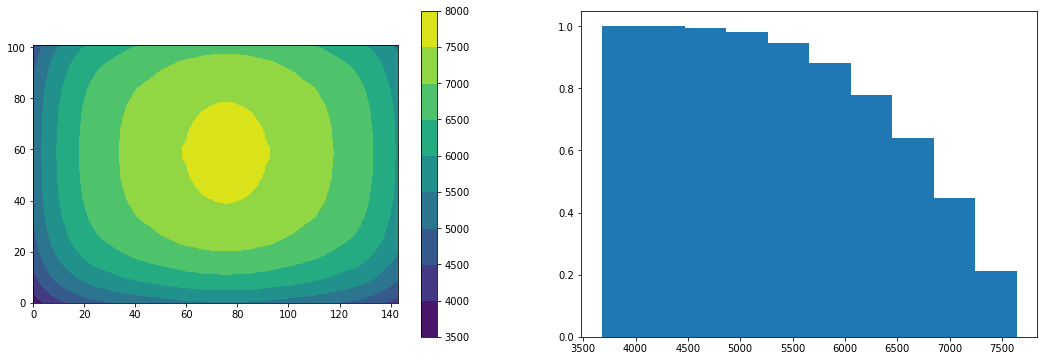

In [31]:
view_field(w, d, morano(lens, auc[0], 1), h, lens, auc[0], PPF)

### Uniform spacing

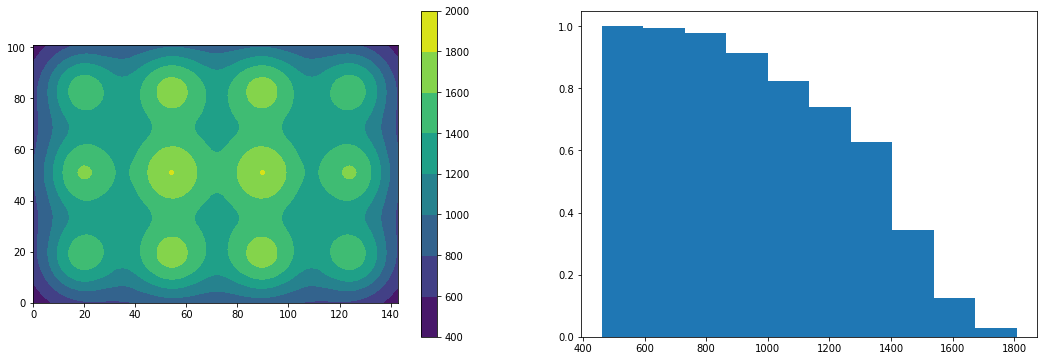

12


In [32]:
pos, n = uniform_spacing_rectangle(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, lens, auc[0], PPF)
print(n)

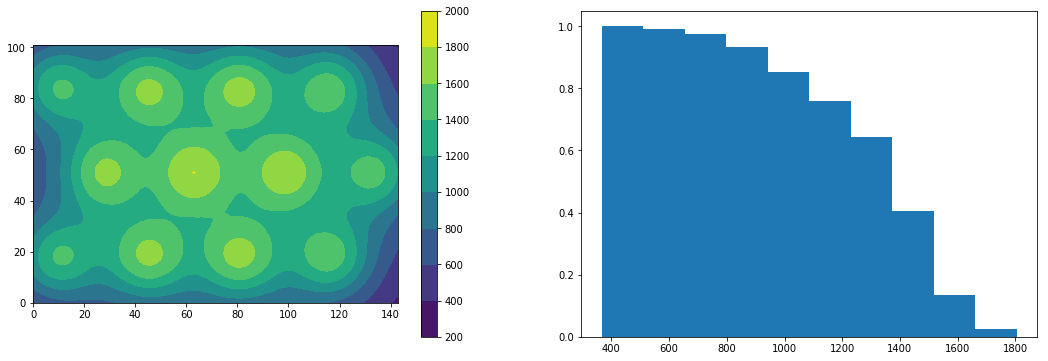

12


In [33]:
pos, n = uniform_spacing_hexagon(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, lens, auc[0], PPF)
print(n)

### Lei

In [34]:
# pos = lsuniformity_loop(w, d, h, int(LED['leds/shelf']), lens, auc[0], PPF * efficiency, stepsize, T)

# view_field(w, d, pos[0], h, lens, auc[0], PPF)

### Su

In [35]:
# pos = rsuniformity(w, d, h, int(LED['leds/shelf']), lens, auc[0], PPF * efficiency, stepsize, T)
# view_field(w, d, pos[0], h, lens, auc[0], PPF)

## Fictive lambertian lens

In [36]:
def fictive_lens_crafter(fwhm):
    m =- np.log(2)/np.log(np.cos(np.radians(fwhm)))
    def fl(x):
        return np.cos(np.radians(x))**m
    return fl

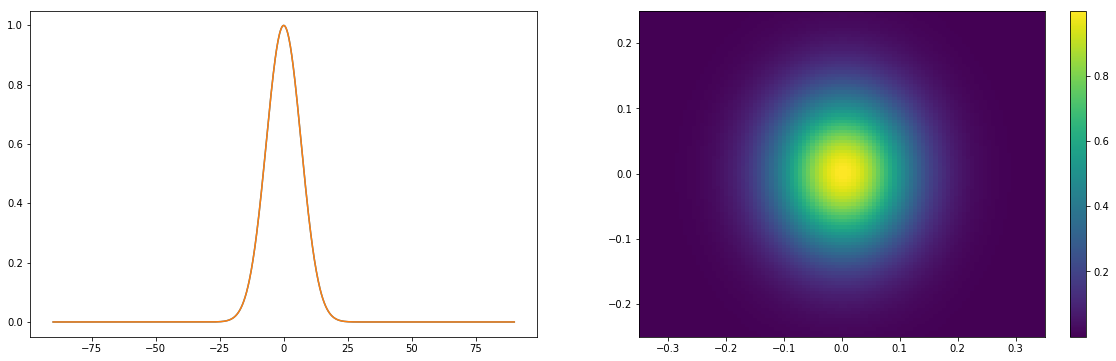

In [37]:
fwhm = 8
lens = fictive_lens_crafter(fwhm)
efficiency = 0.9
show_lens(lens)

In [38]:
auc = sp.integrate.nquad(drd, [[-10, 10], [-10, 10]], args=(h, lens))
auc

(0.044699485923874814, 1.4774446548924956e-08)

### Morano

63 LEDs with an estimated m of 70.88 spaced 0.094m away from each other


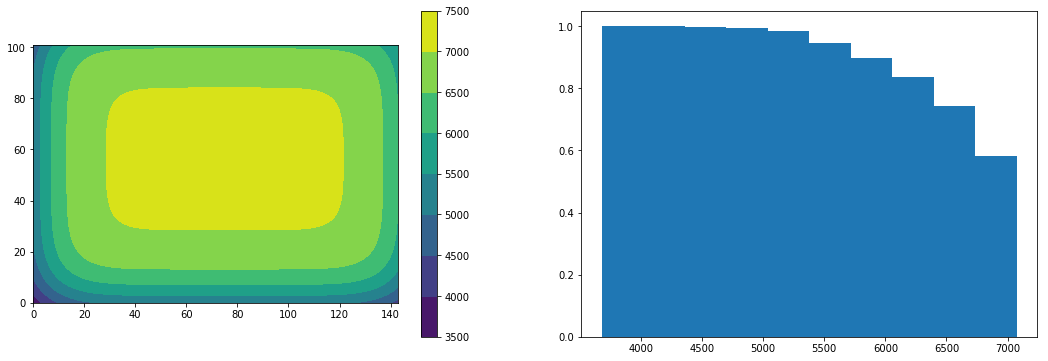

In [39]:
view_field(w, d, morano(lens, auc[0], 1), h, lens, auc[0], PPF)

In [40]:
n = 20
cost_led = LED['$'] * n 
cost_e_month = LED['W'] * n / 1000 * h_light_per_day * 365 * cost_kwh / 12
cost_3y = cost_led + cost_e_month * 36
print(cost_led, cost_e_month, cost_3y)

266.0 16.3276666667 853.796


### Uniform spacing

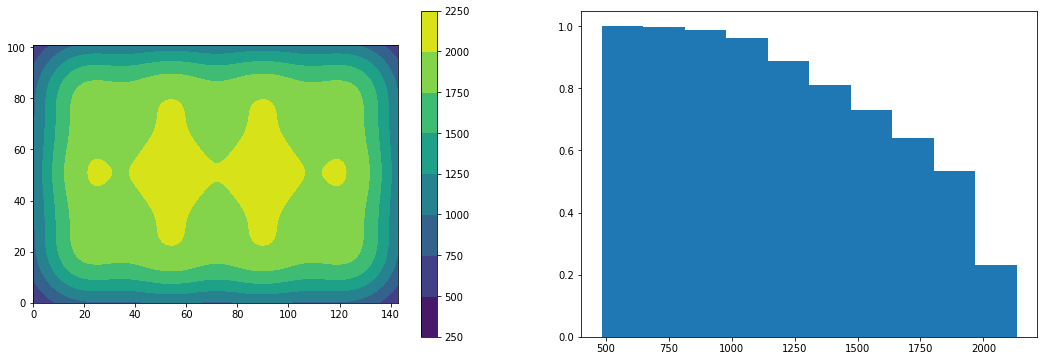

12


In [41]:
pos, n = uniform_spacing_rectangle(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, lens, auc[0], PPF)
print(n)

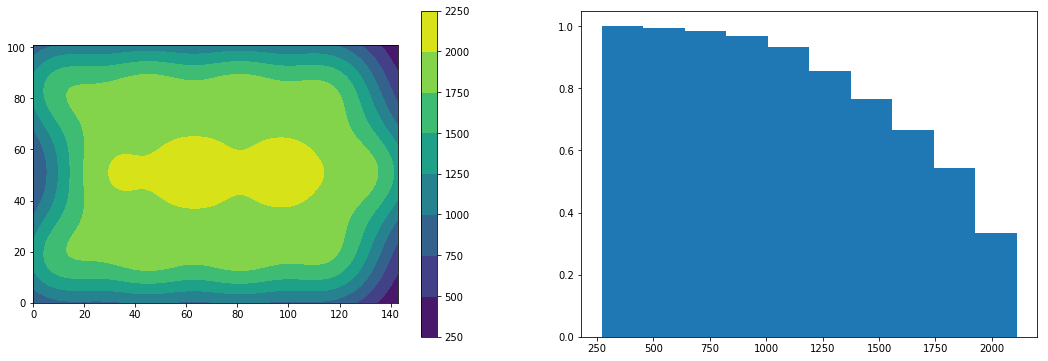

12


In [42]:
pos, n = uniform_spacing_hexagon(w, d, int(LED['leds/shelf']))
view_field(w, d, pos, h, lens, auc[0], PPF)
print(n)

### Lei

### Su

# Updated workflow

The goal is to estimate what would be the best solution considering the following variables:
- Lumens of the LED
- Lumens/W of the LED
- Wavelength distribution of the LED 
- Axial radiation distribution of the reflector

Most of the time, the wavelength distribution of an LED are defined by a brand and series at a given CCT. For example, all Bridgelux V22 share the same wavelength distribution. The manufacturer's specsheet also indicates the specific lumens and lumens/W for each model in the Series. Hence, I could scrape these documents for getting the information.

To ease the work, I can start by searching the LEDs with the highest lumens/W, as lumens/W correlate with the cheapness of the whole solution.

- For each height, for each fwhm (5° to 15°, 0.5° increment), for each LED in the database:
    - Calculate how many LEDs for \$15 per month
        - Take the upper and lower bound that works for the grid (< and > \$15)
    - Score:
        - Uniformity
        - Range of the central 80%
        - Range of the central 90%
        - Amount of light loss
        - Closeness to sunlight.
    - If top 20% of data > sunlight, reduce number of LEDs proportionally to make it sunlight at top 20%
    - Register everything in a pandas DataFrame
    
- Analyse the data:
    - Find the best scores for each height
    - Plot score loss as a function of fwhm, lumen rating, 
    - Plot score as function of fwhm (for fun)
    - Plot best score (of all fwhm) as a function of lumen rating (for fun)
    - Find all solutions that can approximate this fwhm
    - Get score for each solution
    - Plot
    - Keep the best one


- For each LED-reflector pair in the database:
    - Calculate how many LEDs for \$15, considering the price of LEDs as average lm/$
    - Take the upper and lower bound that works for the grid (< and > \$15)
    - Find the optimal height

I should also estimate the field of these guys, because they're really efficient: https://media.digikey.com/pdf/Data%20Sheets/Samsung%20PDFs/LT-Q282A_562A_B22A_Rev0.0_6-19-17.pdf

However, because they're strips, I doubt there's reflectors...

In [3]:
import itertools
heights = range(30, 115, 5)
lumens = range(500, 10500, 500)
lumens_per_watt = range(100, 225, 5)
fwhm = np.arange(5, 15.5, 0.5)
arrangements = itertools.product(heights, lumens, lumens_per_watt, fwhm)
len(list(arrangements))

178500

I have $n_{LED}$ overlapping circles, with $n_{LED}$ being the number of LEDs per shelves. I know from circle packing that the hexagonal conformation is the tightest. I know from Morano what distance between LEDs for a uniform field. If I reverse his equations, I can get, for a square and hexagonal packing of $n_{LED}$ circles, the optimal FWHM for the reflectors.

To find the optimal parameters, fit with parameters distance in x, distance in y, fwhm. Fit to an ideal field, no light loss